### Obtained Perplexity: -18.78, Coherence: 0.378, Best Number of Topics= 80

In [2]:
#Basic Libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint
import sys
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [4]:
#Load Dataset
df=pd.read_csv('/home/smriti/Desktop/NLP/MITACS/Anxiety/Data/CSV/Academic/Acad_2015.csv')
#getting rid of NaN
df=df.replace(np.nan, '', regex=True)
#Combining title and text
df["Text"] = df["Title"] + df["Abstract"]
#Now that we don't need Title or Text, we drop those columns before saving the file
df=df.drop(['Title', 'Abstract'], axis = 1)

/home/smriti/.local/lib/python3.5/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [5]:
df=df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [6]:
df.head()

,StoreId,documentType,year,Text
0,1.75622e+09,Journal Article,2015,The impact of imagery rescripting on memory ap...
1,1.75622e+09,Journal Article,2015,Interpretation modification training reduces s...
2,1.728e+09,Journal Article,2015,Anxiety sensitivity moderates behavioral avoid...
3,1.71568e+09,Feature,2015,The impact of comorbid personality difficultie...
4,1.71568e+09,Feature,2015,Look for good and never give up: A novel atten...


In [7]:
# Convert to list
data=df.Text.values.tolist()
# Remove new line characters
data=[re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data=[re.sub("\'", "", sent) for sent in data]

In [8]:
#Function to clean up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

In [9]:
#Clean up text
data_words=list(sent_to_words(data))
print(data_words[:1])

[['the', 'impact', 'of', 'imagery', 'rescripting', 'on', 'memory', 'appraisals', 'and', 'core', 'beliefs', 'in', 'social', 'anxiety', 'mental', 'images', 'in', 'social', 'anxiety', 'disorder', 'sad', 'are', 'often', 'rooted', 'in', 'memories', 'of', 'formative', 'distressing', 'life', 'events', 'in', 'the', 'present', 'study', 'participants', 'with', 'sad', 'retrieved', 'an', 'idiosyncratic', 'negative', 'mental', 'image', 'and', 'associated', 'memory', 'participants', 'were', 'then', 'randomly', 'assigned', 'either', 'to', 'single', 'session', 'of', 'imagery', 'rescripting', 'ir', 'targeting', 'the', 'retrieved', 'memory', 'or', 'to', 'non', 'intervention', 'control', 'condition', 'no', 'ir', 'outcomes', 'were', 'assessed', 'one', 'week', 'later', 'compared', 'to', 'control', 'participants', 'those', 'who', 'received', 'ir', 'experienced', 'substantial', 'reduction', 'in', 'sad', 'symptoms', 'accompanied', 'by', 'more', 'positive', 'and', 'less', 'negative', 'appraisals', 'of', 'their

In [10]:
# Build the bigram and trigram models
bigram=gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram=gensim.models.Phrases(bigram[data_words], threshold=100)

In [11]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod=gensim.models.phrases.Phraser(bigram)
trigram_mod=gensim.models.phrases.Phraser(trigram)

In [12]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['the', 'impact', 'of', 'imagery', 'rescripting', 'on', 'memory', 'appraisals', 'and', 'core_beliefs', 'in', 'social', 'anxiety', 'mental', 'images', 'in', 'social', 'anxiety', 'disorder', 'sad', 'are', 'often', 'rooted', 'in', 'memories', 'of', 'formative', 'distressing', 'life_events', 'in', 'the', 'present', 'study', 'participants', 'with', 'sad', 'retrieved', 'an', 'idiosyncratic', 'negative', 'mental', 'image', 'and', 'associated', 'memory', 'participants', 'were', 'then', 'randomly_assigned', 'either', 'to', 'single', 'session', 'of', 'imagery', 'rescripting', 'ir', 'targeting', 'the', 'retrieved', 'memory', 'or', 'to', 'non', 'intervention', 'control', 'condition', 'no', 'ir', 'outcomes', 'were', 'assessed', 'one', 'week', 'later', 'compared', 'to', 'control', 'participants', 'those', 'who', 'received', 'ir', 'experienced', 'substantial', 'reduction', 'in', 'sad', 'symptoms', 'accompanied', 'by', 'more', 'positive', 'and', 'less', 'negative', 'appraisals', 'of', 'their', 'memori

In [13]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


In [14]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [29]:
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

# Create Dictionary needed for topic modelling
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=85,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

[['impact', 'imagery', 'rescripte', 'memory', 'appraisal', 'core_belief', 'social', 'anxiety', 'mental', 'image', 'social', 'anxiety', 'disorder', 'sad', 'often', 'root', 'memory', 'formative', 'distress', 'present', 'study', 'participant', 'sad', 'retrieve', 'idiosyncratic', 'negative', 'mental', 'image', 'associate', 'memory', 'participant', 'randomly_assigne', 'single', 'session', 'imagery', 'rescripting', 'ir', 'target', 'retrieve', 'memory', 'non', 'intervention', 'control', 'condition', 'outcome', 'assess', 'week', 'later', 'compare', 'control', 'participant', 'receive', 'experience', 'substantial', 'reduction', 'sad', 'symptom', 'accompany', 'positive', 'less', 'negative', 'appraisal', 'memory', 'moreover', 'relative', 'participant', 'report', 'marked', 'shift', 'accuracy', 'memory', 'derive', 'negative', 'self', 'other', 'world', 'result', 'support', 'promise', 'ir', 'stand', 'alone', 'intervention', 'sad', 'suggest', 'important', 'direction', 'future', 'research', 'enhance', '

In [30]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(7,
  '0.000*"hip" + 0.000*"hcd" + 0.000*"uniqueness" + 0.000*"numbing" + '
  '0.000*"hyperarousal" + 0.000*"resolution" + 0.000*"precentral" + '
  '0.000*"morphometric" + 0.000*"morphological" + 0.000*"morphologic"'),
 (66,
  '0.000*"hip" + 0.000*"hcd" + 0.000*"uniqueness" + 0.000*"numbing" + '
  '0.000*"hyperarousal" + 0.000*"resolution" + 0.000*"precentral" + '
  '0.000*"morphometric" + 0.000*"morphological" + 0.000*"morphologic"'),
 (18,
  '0.000*"hip" + 0.000*"hcd" + 0.000*"uniqueness" + 0.000*"numbing" + '
  '0.000*"hyperarousal" + 0.000*"resolution" + 0.000*"precentral" + '
  '0.000*"morphometric" + 0.000*"morphological" + 0.000*"morphologic"'),
 (54,
  '0.000*"hip" + 0.000*"hcd" + 0.000*"uniqueness" + 0.000*"numbing" + '
  '0.000*"hyperarousal" + 0.000*"resolution" + 0.000*"precentral" + '
  '0.000*"morphometric" + 0.000*"morphological" + 0.000*"morphologic"'),
 (1,
  '0.000*"hip" + 0.000*"hcd" + 0.000*"uniqueness" + 0.000*"numbing" + '
  '0.000*"hyperarousal" + 0.000*"resolut

In [31]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -18.663110863575998


In [32]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3760345988119895


In [19]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df=pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row=row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row=sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j==0:  # => dominant topic
                wp=ldamodel.show_topic(topic_num)
                topic_keywords=", ".join([word for word, prop in wp])
                sent_topics_df=sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
     # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [20]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,31.0,0.4950,"sad, task, social, participant, attentional, d...","[impact, imagery, rescripte, memory, appraisal..."
1,1,3.0,0.4642,"bias, anxious, threat, training, post, cue, co...","[interpretation, modification, training, reduc..."
2,2,14.0,0.2041,"symptom, anxiety, relationship, predict, prosp...","[anxiety, sensitivity, moderate, behavioral, a..."
3,3,20.0,0.3617,"treatment, outcome, improvement, week, care, p...","[impact, comorbid, personality, difficulty, re..."
4,4,20.0,0.1934,"treatment, outcome, improvement, week, care, p...","[look, good, never, give, novel, attention, tr..."


In [21]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,31.0,0.4950,"sad, task, social, participant, attentional, d...","[impact, imagery, rescripte, memory, appraisal..."
1,1,3.0,0.4642,"bias, anxious, threat, training, post, cue, co...","[interpretation, modification, training, reduc..."
2,2,14.0,0.2041,"symptom, anxiety, relationship, predict, prosp...","[anxiety, sensitivity, moderate, behavioral, a..."
3,3,20.0,0.3617,"treatment, outcome, improvement, week, care, p...","[impact, comorbid, personality, difficulty, re..."
4,4,20.0,0.1934,"treatment, outcome, improvement, week, care, p...","[look, good, never, give, novel, attention, tr..."
5,5,20.0,0.1456,"treatment, outcome, improvement, week, care, p...","[feasibility, improve, childhood, anxiety, dis..."
6,6,15.0,0.5615,"anxiety, study, use, abstract, source_journal,...","[discriminant_validity, construct, derive, sel..."
7,7,13.0,0.2954,"intervention, therapy, treatment, cbt, efficac...","[computerised, cbt, depressed, adolescent, ran..."
8,8,32.0,0.4405,"depression, symptom, risk, anxiety, associate,...","[moderator, effect, psychological, interventio..."
9,9,20.0,0.2325,"treatment, outcome, improvement, week, care, p...","[cognitive, behavior, therapy, comorbid, migra..."


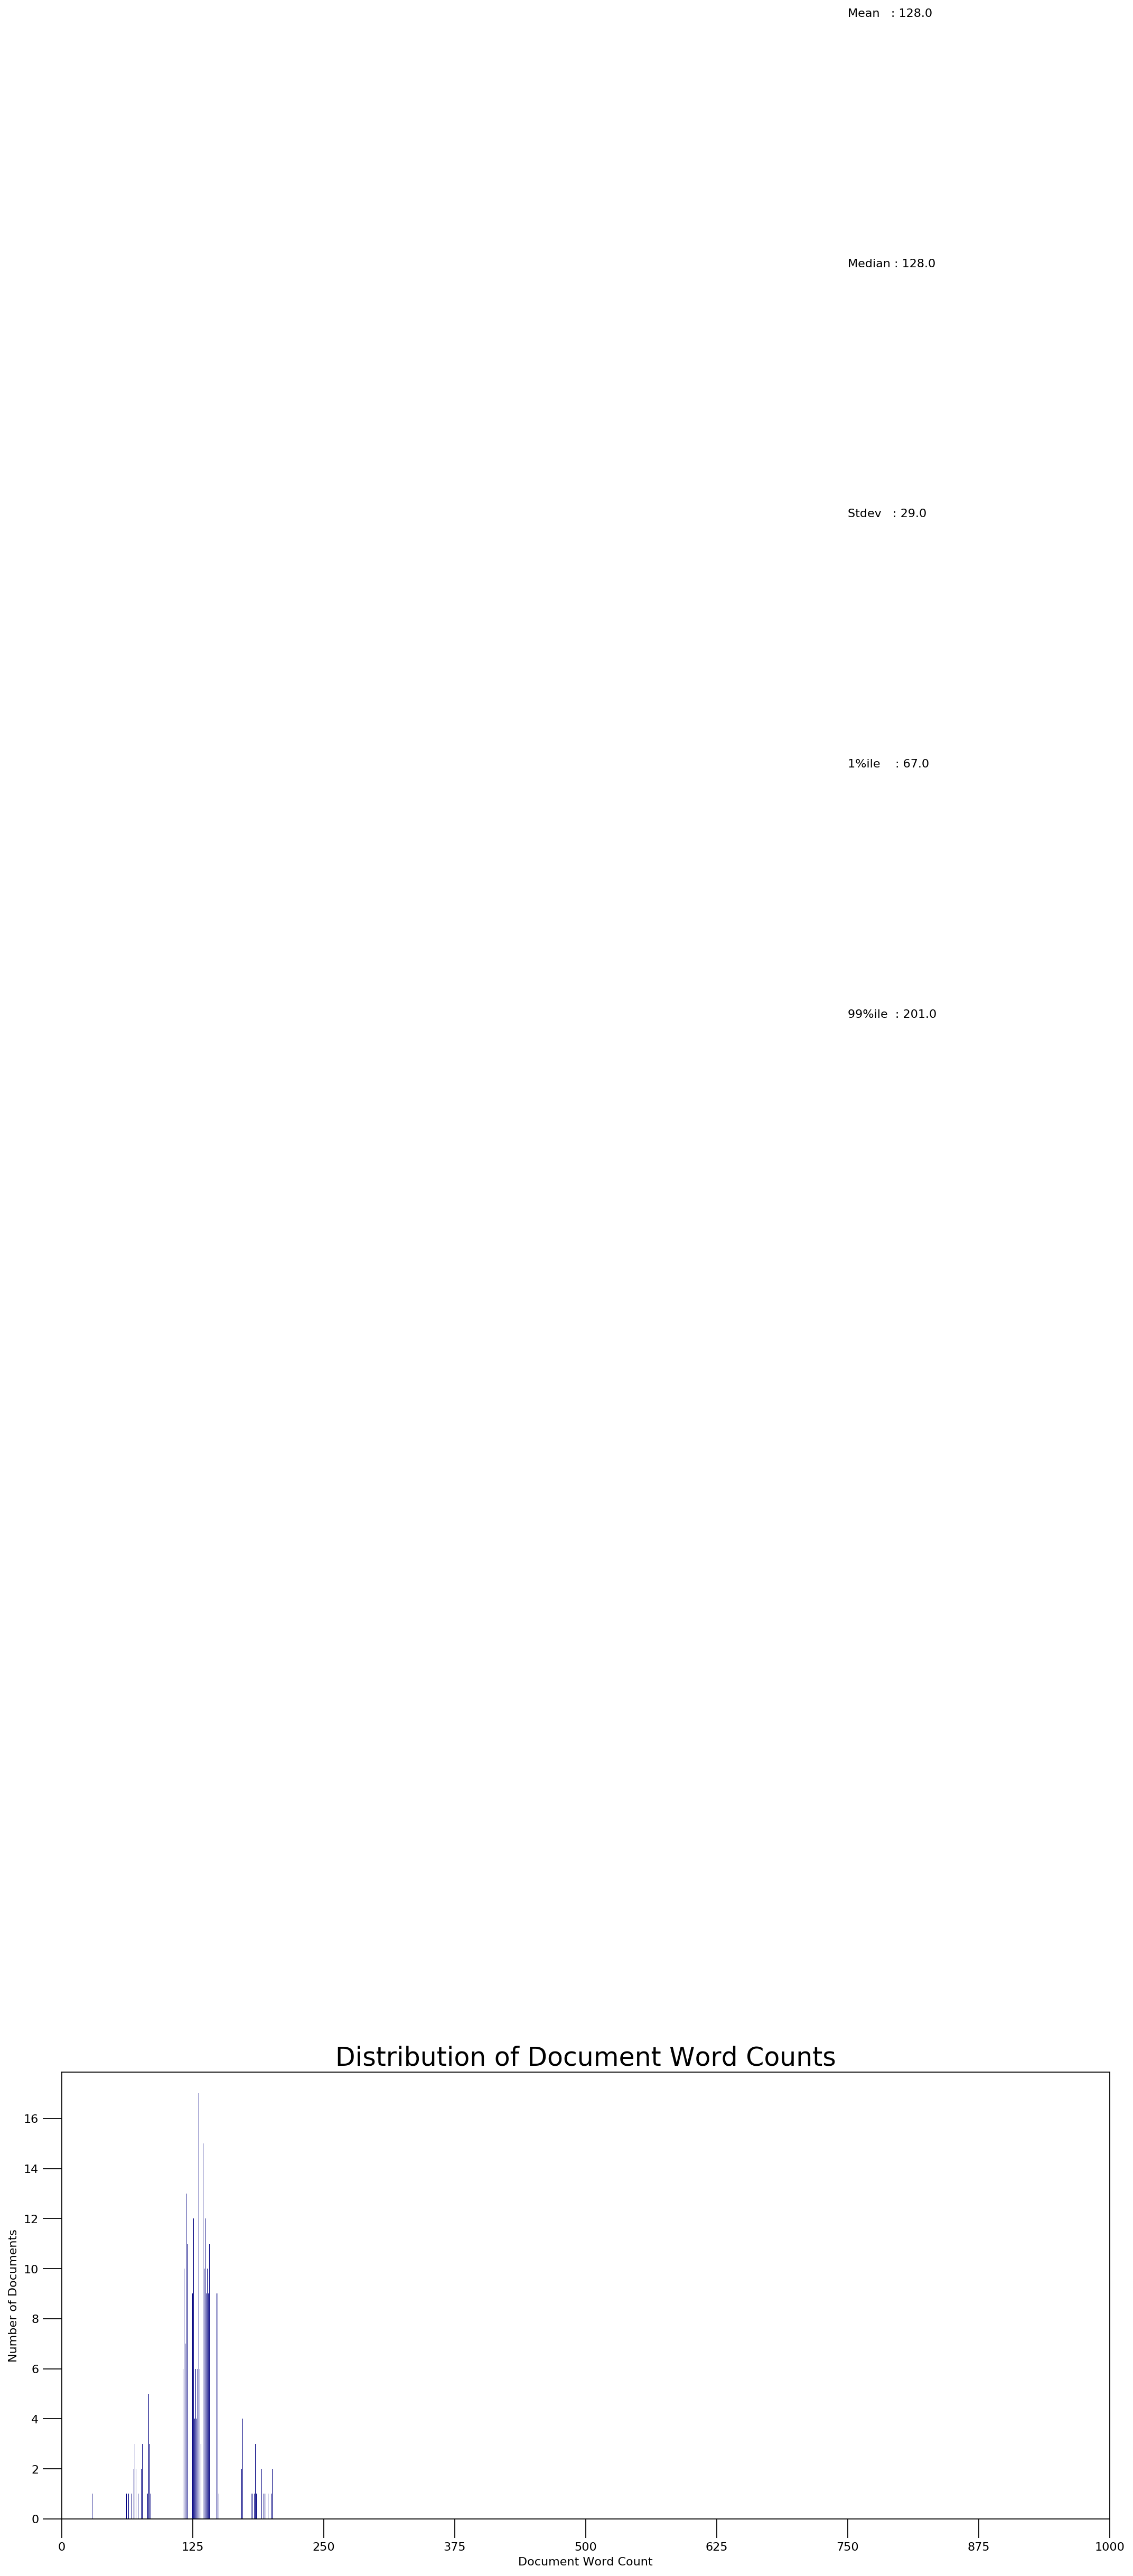

In [22]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

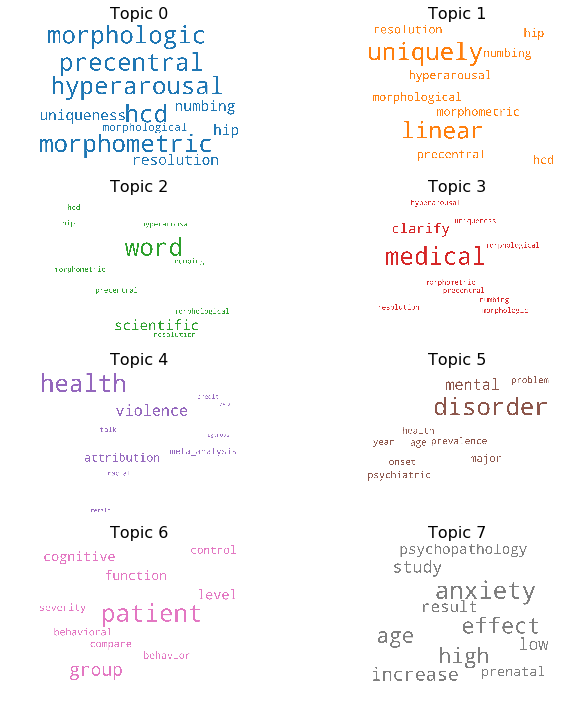

In [23]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(4, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [24]:
df_dominant_topic.to_csv("Journal2015.csv")

In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(alpha='auto', corpus=corpus, num_topics=20, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [26]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=100, step=6)

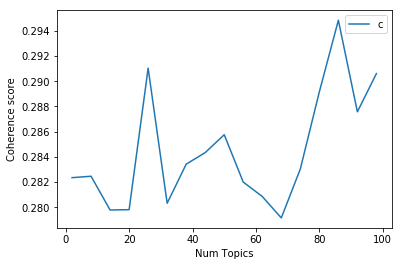

In [28]:
# Show graph
limit=100; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')